<a href="https://colab.research.google.com/github/Cool-buddies-of-ENEL645/OurAwesomeFinalProject/blob/main/Freeze_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

(The data for this demo can be downloaded here: https://drive.google.com/file/d/1uRU3jSSv6r7KvuzsCforSzq0-kNuDctI/view?usp=sharing)

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.

## Step-by-step Procedure

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling (use the same scaling technique as the one the pretrained model originally used)
    - [tf.keras.applications.resnet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input)
3. One hot encoding
4. Define your callbacks (save your model, patience, etc.)
5. Set up data Augmentation

6. Transfer Learning
    
    6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    6.3. Add a top (i.e., the prediction layers)
    
    6.4  Train the model using your dataset
    
    6.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    6.6 If you are satisfied with the train and validation performance go to the next step
    
    6.7 If you are not satisfied with the train and validation performance go back to step 6.1.

7. Test your model on the test and extract relevant metrics

In [ ]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
import pickle

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Set up your data augmentation

In [ ]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 64 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/Garbage/Garbage-dataset-pre-processed/Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/Garbage/Garbage-dataset-pre-processed/Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


## 2. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_it = "garbage_classifier_In_V3_it.h5"
model_name_ft = "garbage_classifier_In_V3_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 3. Transfer Learning

3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

3.3. Add a top (i.e., the prediction layers)

In [ ]:
img_height = 256
img_width = 256

# Defining the model
base_model = tf.keras.applications.InceptionV3( #EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False
# base_model.trainable = True

x1 = base_model(base_model.input, training = False)
# x1 = base_model(base_model.input, training = True)
x2 = tf.keras.layers.Flatten()(x1)

# x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
# X2 = tf.keras.layers.Dense(64, activation='relu')(x2)
# x2 = tf.keras.layers.Dropout(0.2)(x2)
# X2 = tf.keras.layers.Dense(16, activation='relu')(x2)
# x2 = tf.keras.layers.Dropout(0.2)(x2)


out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 4)                 294916    
                                                                 
Total params: 22,097,700
Trainable params: 294,916
Non-trainable params: 21,802,784
_________________________________________________________________
None


## 3.4 Train the model using your dataset

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(train_generator, epochs=20, verbose = 1, \
                      callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

Epoch 1/20
81/81 [==============================] - 1485s 18s/step - loss: 0.6822 - accuracy: 0.7431 - val_loss: 0.5834 - val_accuracy: 0.7827 - lr: 1.0000e-04
Epoch 2/20
81/81 [==============================] - 127s 2s/step - loss: 0.4683 - accuracy: 0.8323 - val_loss: 0.6859 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 3/20
81/81 [==============================] - 126s 2s/step - loss: 0.3944 - accuracy: 0.8552 - val_loss: 0.5454 - val_accuracy: 0.7979 - lr: 1.0000e-04
Epoch 4/20
81/81 [==============================] - 126s 2s/step - loss: 0.3593 - accuracy: 0.8644 - val_loss: 0.5790 - val_accuracy: 0.7729 - lr: 1.0000e-04
Epoch 5/20
81/81 [==============================] - 126s 2s/step - loss: 0.3256 - accuracy: 0.8751 - val_loss: 0.5816 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 6/20
81/81 [==============================] - 127s 2s/step - loss: 0.3029 - accuracy: 0.8891 - val_loss: 0.4898 - val_accuracy: 0.8362 - lr: 1.0000e-04
Epoch 7/20
81/81 [==============================] 

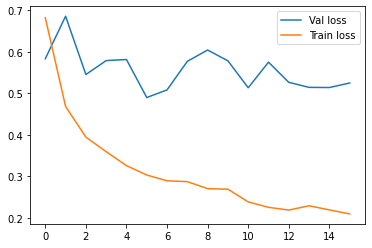

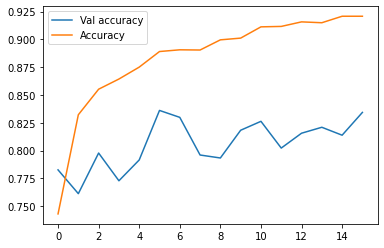

In [ ]:
it_file = open("it_history.pkl", "wb")
pickle.dump(history_it.history, it_file)
it_file.close()

plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()



In [ ]:
# Fine-tuning the model
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 4)                 294916    
                                                                 
Total params: 22,097,700
Trainable params: 22,063,268
Non-trainable params: 34,432
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 146s 2s/step - loss: 0.2781 - accuracy: 0.8941 - val_loss: 0.5157 - val_accuracy: 0.8148 - lr: 1.0000e

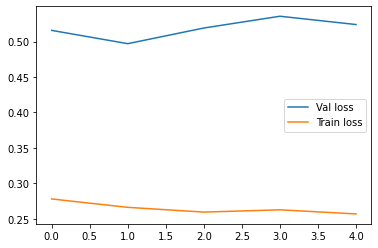

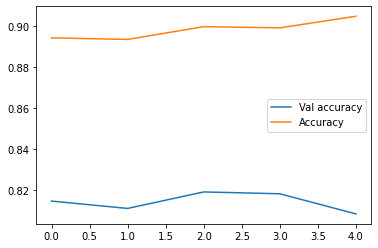

In [ ]:
plt.figure()
plt.plot(history_ft.history["val_loss"], label = "Val loss")
plt.plot(history_ft.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ft.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

ft_file = open("ft_history.pkl", "wb")
pickle.dump(history_ft.history, ft_file)
it_file.close()

## 4. Test your model on the test set and extract relevant metrics

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/Garbage/Garbage-dataset-pre-processed/Test",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/Garbage/Garbage-dataset-pre-processed/Test",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [ ]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate(test_generator)

# Testing the model in the fine tuning
model = tf.keras.models.load_model(model_name_ft)
model.evaluate(test_generator)


13/13 [==============================] - 18s 1s/step - loss: 0.6593 - accuracy: 0.7509


[0.6592825651168823, 0.7509293556213379]

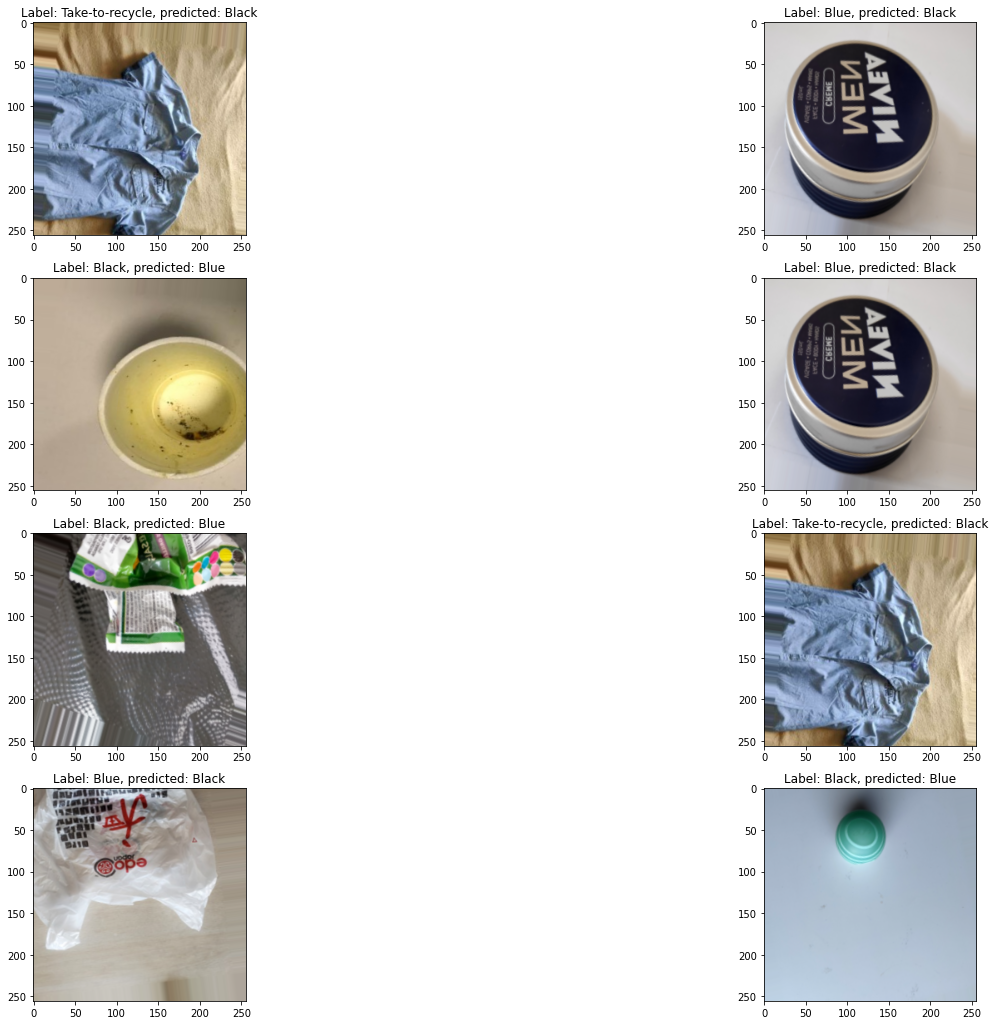

In [ ]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = True)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

def print_report_conf_matrix(model):
  print("--------------------------------------------------------")
  print(model.name)
  print("--------------------------------------------------------")
  Ypred = model.predict(Xtest).argmax(axis = 1)
  report = classification_report(Ytest, Ypred)
  print(report)
  plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)

--------------------------------------------------------
model
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        19
           1       0.53      0.56      0.55        16
           2       0.88      0.94      0.91        16
           3       0.79      0.85      0.81        13

    accuracy                           0.70        64
   macro avg       0.71      0.72      0.71        64
weighted avg       0.70      0.70      0.70        64

Confusion matrix, without normalization


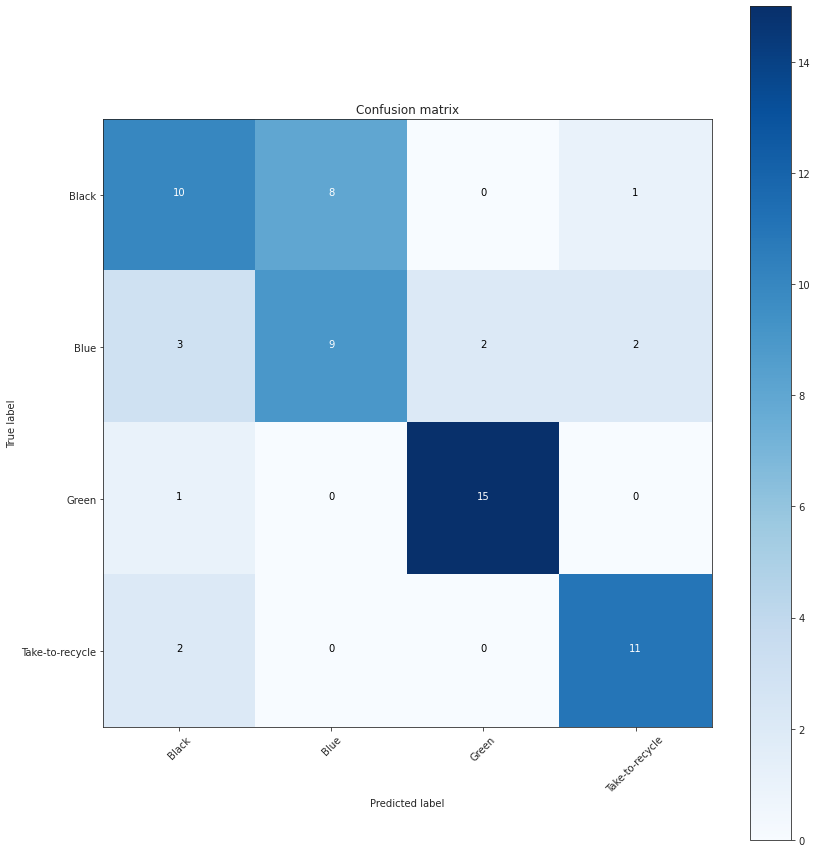

In [ ]:
print_report_conf_matrix(model)